# Loading Image Data

* 본 notebook에서는 data를 불러오고 epoch, batch화 하는 방법을 실습합니다
* 이를 위해서 Kaggle에서 찾을 수 있는 [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats)을 활용합니다



# Kaggle 에서 자료 받기

* Kaggle에서 자료를 받습니다
[dataset URL](https://www.kaggle.com/datasets/dlsunghlim/hallym-deep-learning-dogcat-data)
* Download를 클릭하여 zip file 다운로드
* 다운 받은 파일을 본 notebook과 동일한 폴더에서 압축을 풀고, 해당 폴더의 이름을 
`Cat_Dog_data` 로 변경해주세요. 대소문자 구분해주세요.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper  # py.file 불러오기

### Dataset Class

- torch.datasets subclass method (https://pytorch.org/vision/stable/datasets.html)
- `Pytorch`가 dataset을 어떻게 읽을지 알려주는 class
- 필수 method로 `__len__`와 `__getitem__()` 이 필요함


```python:

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)  # 이미지 label되어있는 csv파일
        self.img_dir = img_dir
        self.transform = transform  # 이미지 resize
        self.target_transform = target_transform
        
    # 총 몇 개가 있는지 정의하는 함수(전체 데이터 크기)
    def __len__(self):    
        return len(self.img_labels)
    
    # 원하는 인덱스를 줬을 때, 그 데이터를 불러오는 함수
    def __getitem__(self, idx):  
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample
        
```


### Dataset example: ImageFolder
- subclass of DatasetFolder 


* Image data를 읽어드리는 작업은 `torchvision` ([documentation](https://pytorch.org/vision/stable/index.html))에 포함된 `datasets.ImageFolder`을 활용하여 수행합니다.

* 예를 들어서 `ImageFolder` 다음과 같이 활용합니다:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

* 여기서 `'path/to/data'` data가 포함된 data directory이고, [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html)은 `torchvision` module에 포함된 여러 parameter를 입력하기 위하여 사용자가 정의하는 여러가지 변환 parameter 입니다. 
* `ImageFolder`는 다음과 같은 형태로 file과 directory가 생성되었을 것이라고 가정합니다:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

* 위에서 중요한 구분은 각 class별로 directory가 따로 생성된 것입니다 (`cat` and `dog`)
* Pytorch에서는 각 image를 directory 이름에 맞춰서 label을 정합니다. 즉, `123.png` 는 label `cat`으로 읽어드립니다




In [2]:
data_dir = 'Cat_Dog_data/train'
dataset = datasets.ImageFolder(data_dir)

In [3]:
dataset

Dataset ImageFolder
    Number of datapoints: 22500
    Root location: Cat_Dog_data/train

In [4]:
dataset.__len__()  # 전체 이미지 개수

22500

In [5]:
dataset.__getitem__(1000)

(<PIL.Image.Image image mode=RGB size=500x453>, 0)

고양이는 0 class   
강아지는 1 class

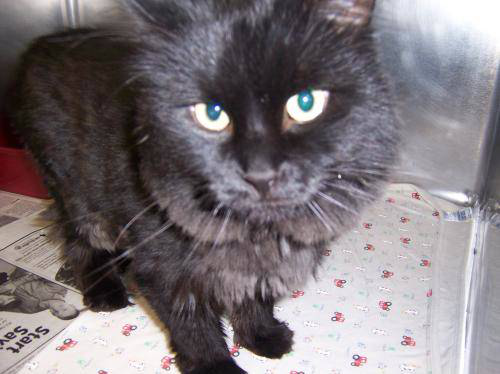

In [6]:
dataset.__getitem__(100)[0]  # 이미지 사이즈가 천차만별  # 0class의 100번째 그림

고양이는 0클래스, 강아지는 1클래스

### Transforms (https://pytorch.org/vision/stable/transforms.html)

* 위 형식에서 알아본 것과 같이, `ImageFolder`를 사용하여 data를 읽어드리는 경우 몇 가지 transform을 정의해야합니다

* 예를 들어서, 각 이미지 파일은 서로 크기가 다를 수 있는데, 같은 크기로 (input size)를 맞춰줘야합니다
  * 이경우는 normalize `transforms.Normalize()`, 크기를 변경하거나 `transforms.Resize()`, 잘라내거나 `transforms.CenterCrop()`, `transforms.RandomResizedCrop()` 합니다
* 물론 image 파일을 `transforms.ToTensor()`를 활용하여 Pytorch tensor로 바꿔주는 작업도 해야하고요
* 일반적으로 이와 같이 필요한 transformation을 `transforms.Compose()`라는 모듈을 사용하여 정렬합니다. 그러면 알아서 sequential하게 수행할 수 있는 형태로 자료구조를 만들어 줍니다.

* 아래 예시는 scale, crop, 한 후에 tensor로 변경하는 방법의 예시 입니다:

```python
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

```



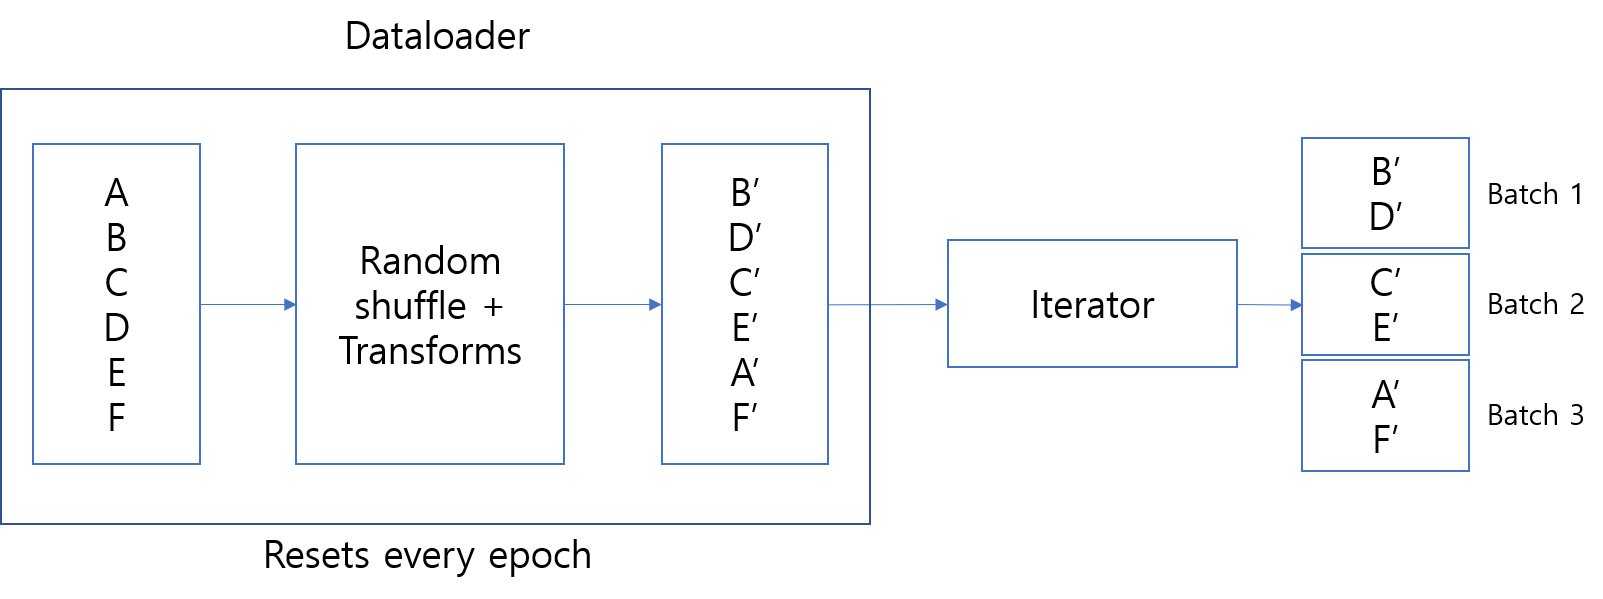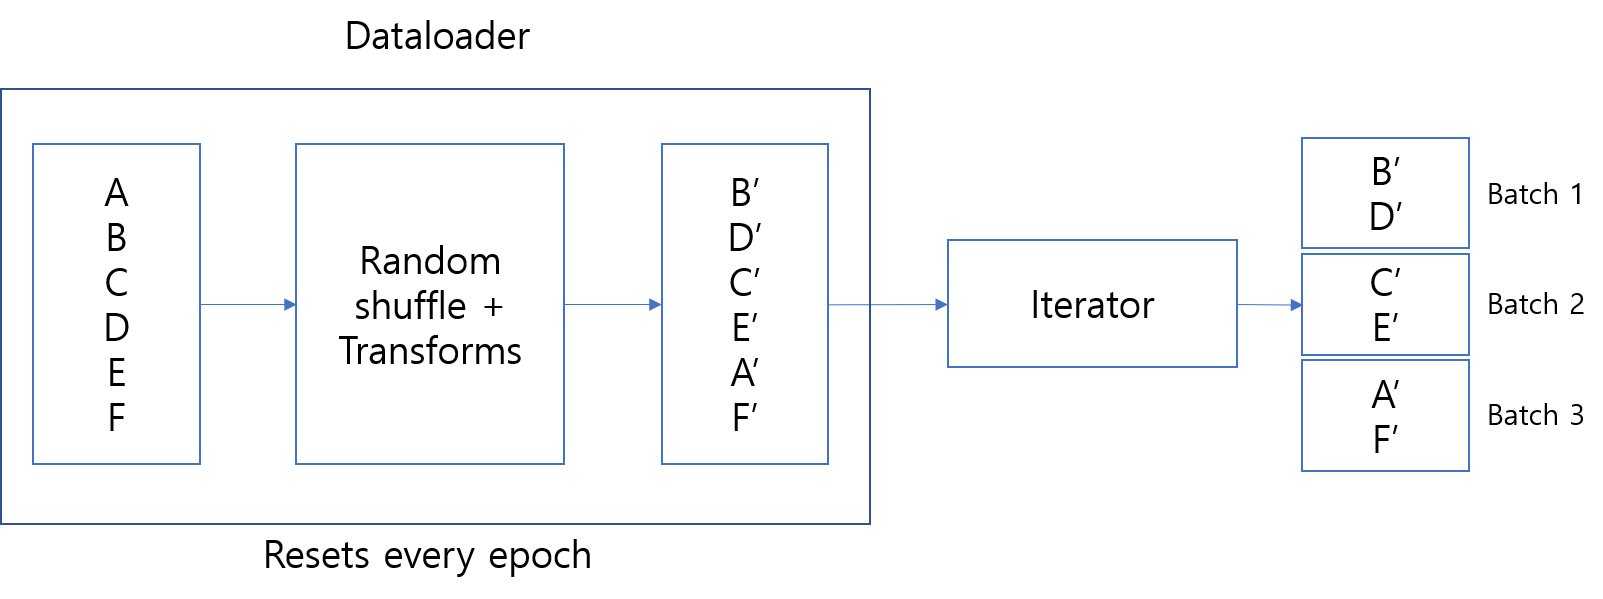### Data Loaders

<img src='assets/dataloader.png' width=850>

* `ImageFolder`를 load 한 후에는 [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)로 넘겨줘야 합니다
* `DataLoader`는 `ImageFolder`로 부터 받은 dataset을 받아서 image와 해당 label을 여러개의 batch 로 정리하여 return 합니다
  * 이때, 설정에서 batch 크기등을 설정할 수 있습니다.
* `DataLoader`를 받는 방법은 다음과 같습니다:

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

* 위 명령어에서 `dataloader`는 [generator](https://bluese05.tistory.com/56) 입니다. Iterator 설명링크도 generator 링크에 포함되어 있으나 참고하세요.
* 즉 data를 부르기 위해서는 loop를 돌면서 부르거나, iterator로 변경해서 `next()`를 call하면 됩니다

```python
# Looping: 각 loop에서 batch를 받는다
for images, labels in dataloader:
    pass

# 한개의 batch를 받는다
images, labels = next(iter(dataloader))
```
 


In [12]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),  # (픽셀이) 0~1사이의 tensor가 존재
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ([RGB에 해당하는 평균값], [RGB로 나눠준 표준편차])
                               ])
# 이미지를 불러올 때 transform에 있는 전처리를 하고 불러와라
dataset = datasets.ImageFolder('Cat_Dog_data/train', transform=transform)

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)  # 이미지32장씩 한 배치를 만든다, 에폭이 끝날 때마다 섞어준다.

In [14]:
dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


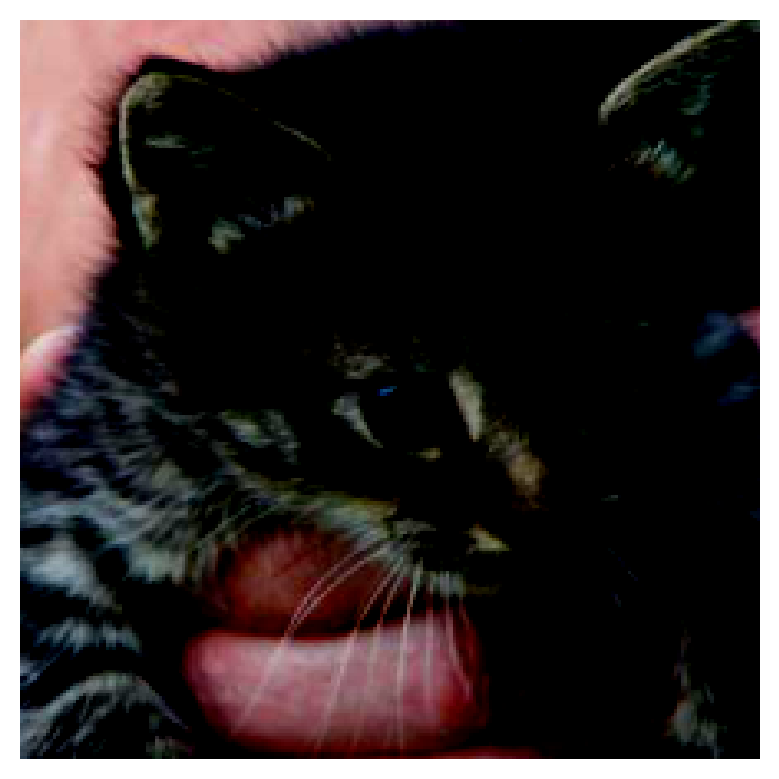

In [15]:
# Run this to test your data loader
# 32개 중 0번인덱스 사진(다시 실행하면 다음 32개 중 0번 인덱스 사진 출력)

images, labels = next(iter(dataloader))  # iter함수를 통해서 개체로 바꿔준다
helper.imshow(images[0], normalize=False)
print(labels[0])

위 과정을 성공했으면, 아래와 같은 형태로 이미지가 보일 것입니다 (랜덤하게 image file을 결정하기 때문에 사진을 다르게 나올 것입니다):

<img src='assets/cat_cropped.png' width=244>

## Data Augmentation

* 기계학습의 성능은 일반적으로 데이터의 양에 많을 수록 좋은 성능을 갖습니다
* 데이터의 양을 늘리는 한가지 방법은 데이터 random하게 변경하여 새로운 데이터로 사용하는 방법입니다 `data augementation`
* 예를 들어서 random하게 image를 rotate, mirror, scale, crop 하여 training 하는 방법이 있습니다

* Random하게 rotate, scale, crop, flip을 하는 transform 방법은 아래와 같습니다:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),     # 그림을 30도씩 회전
                                       transforms.RandomResizedCrop(224), # 크기 랜덤하게 한 다음, 224사이즈로 자르기
                                       transforms.RandomHorizontalFlip(), # 랜덤하게 좌우반전(어떤거는 하고 어떤거는 안 하고)
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```
* 추가로 사용할 수 있는 방법들은 (https://pytorch.org/vision/stable/transforms.html)에서 확인하세요
  * `transforms.RandomRotation()`
  * `transforms.RandomVerticalFlip(p=0.5)`   # 상하반전(p=확률) / 50%만 반전
  * `transforms.GaussianBlur(kernel_size, sigma=(0.1, 2.0))`  # 배경을 뿌옇게 만드는것  / kernel_size : 몇 개의 픽셀들 모아서 할것인가
  * `transforms.RandomHorizontalFlip(p=0.5)`  # 좌우반전
* 위 과정에서 추가하는 `transforms.Normalize`는 image의 값을 정규화하는 과정인데, 매우 유용하고 성능을 개선할 수 있는 중요한 단계입니다
* 평균값 리스트와 표준편차 리스트를 입력하면, 각 color channel (RGB)는 다음 공식에 의해서 normalize 됩니다

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

* 여기서 `mean`을 빼는 작업은 data를 `0`을 중심으로 두는 변형을 하고, `std`를 나누는 것은 값들을 `-1`에서 `1`사이로 좁히는 작업을 수행합니다
* Normalization 과정 없이 training을 하는 경우, 느린 속도와 성능이 좋지 못한 경우가 많습니다

* 모든 가능한 transform은 [the available transforms here](https://pytorch.org/vision/stable/transforms.html) 찾아보실 수 있습니다
* Validation/Testing 과정에서는 위와 같은 image를 인공적으로 변형하는 augmentation을 수행하지 않고, 원 이미지를 통해서만 test를 합니다



In [16]:
data_dir = 'Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# 배치사이즈에 맞춰서 데이터 loader에 올린다.
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### trainloader에는 실행할 때마다 그림이 바뀌는 것을 볼 수 있음 -> 이미지 증강 기법

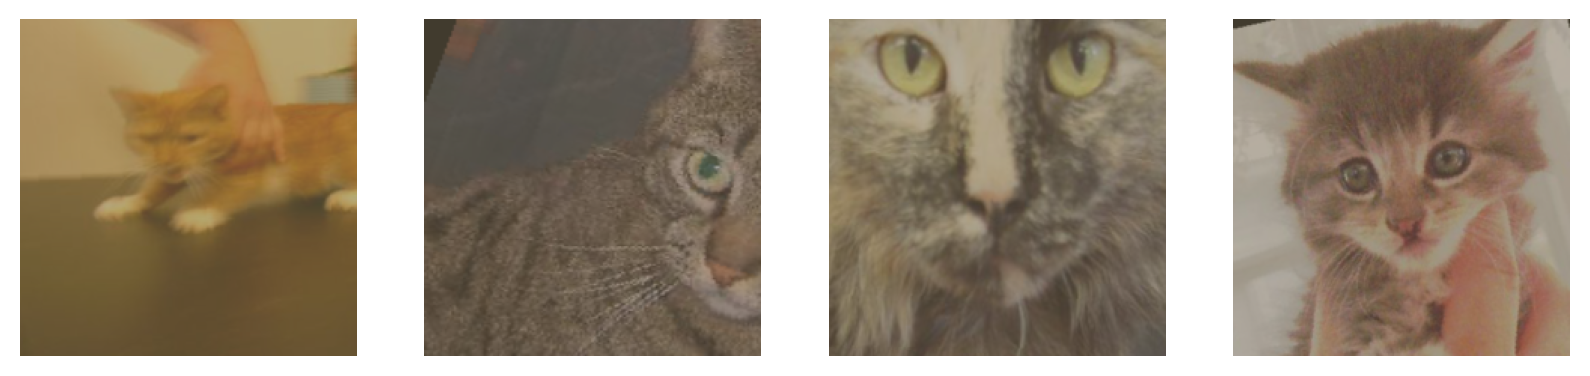

In [17]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

# 32개씩 받는 작업
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)  # 4개만 출력
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=True)

### testloader에는 그림이 바뀌지 X

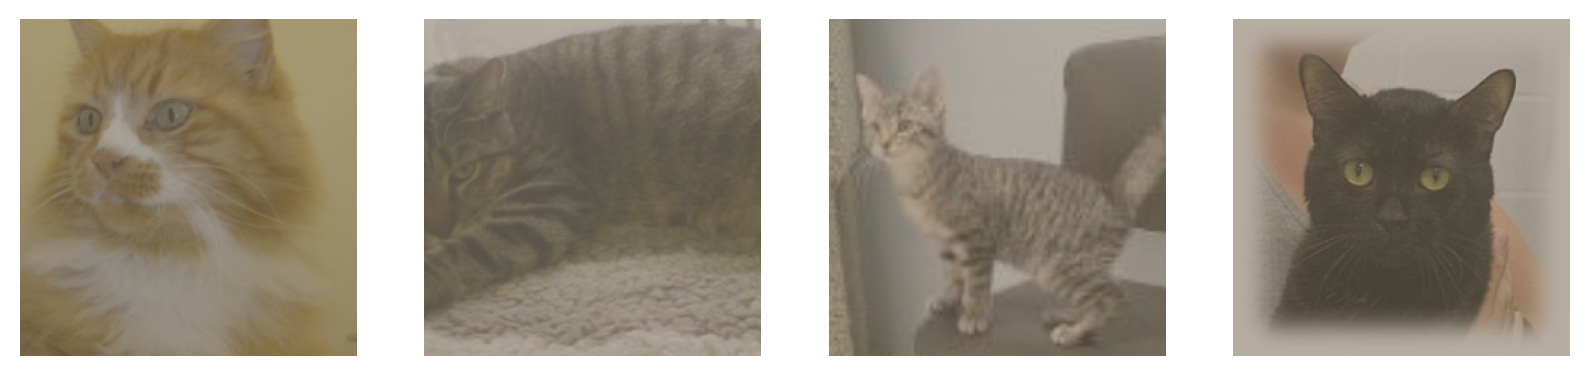

In [18]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=True)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>